# *SDS_Benchmark*: Compare satellite-derived shoreline to groundtruth


This notebook shows how to compare the satellite-derived shorelines from the different submissions at the 4 different sites:
- Narrabeen, Australia [ref](https://www.nature.com/articles/sdata201624)
- Duck, North Carolina, USA [ref](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2014JC010329)
- Truc Vert, France [ref](https://www.nature.com/articles/s41597-020-00750-5#Tab2)
- Torrey Pines, California, USA [ref](https://www.nature.com/articles/s41597-019-0167-6)

## Initial settings

To run this notebook you will need basic Python packages installed: `numpy`, `scipy`, `pandas`, `matplotlib`, `pytz`.

If you have [CoastSat](https://github.com/kvos/CoastSat) installed, you can activate that envrionment as it has all the necessary packages.

In [13]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime, timedelta
from scipy import interpolate
from scipy import stats
import pytz
import json
import pdb
# import utils module located in the repository (utils.py)
import utils

# filepaths to all the datasets
fp_datasets = os.path.join(os.path.join(os.getcwd(),'datasets'))
names_datasets = os.listdir(fp_datasets)
names_datasets = [_ for _ in names_datasets if _ not in ['README.md','sites_info.txt']]
print('\nBenchmark datasets available:\n%s'%(names_datasets))
                
# load site info dict if exists or create
fp_info = os.path.join(fp_datasets,'sites_info.txt')
if os.path.exists(fp_info):
    with open(fp_info,'r') as f: sites_info = json.load(f)  
    print('\nLoaded sites_info.txt.')
    for key in sites_info.keys(): print('%s: %s'%(key,sites_info[key]))

# filepaths to submissions
fp_submissions = os.path.join(os.path.join(os.getcwd(),'submissions'))
submissions = [_ for _ in os.listdir(fp_submissions) if _ not in ['README.md','example_submission']]
print('\nSubmitted shorelines: %s'%submissions)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Benchmark datasets available:
['CALAMILLOR', 'DUCK', 'NARRABEEN', 'TORREYPINES', 'TRUCVERT']

Loaded sites_info.txt.
NARRABEEN: {'beach_slope': 0.1, 'contour_level': 0.7, 'epsg': 28356}
DUCK: {'beach_slope': 0.1, 'contour_level': 0.585, 'epsg': 32119}
TRUCVERT: {'beach_slope': 0.05, 'contour_level': 1.5, 'epsg': 32630}
TORREYPINES: {'beach_slope': 0.045, 'contour_level': 0.792, 'epsg': 26946}
CALAMILLOR: {'beach_slope': 0.1, 'contour_level': 0, 'epsg': 2062}

Submitted shorelines: ['team_CASSIE', 'team_CoastSat', 'team_Deltares', 'team_UQMAO']


### Format submitted outputs

Read the submitted files and convert everything to a standard format that can be easily manipulated.

In [18]:
# create a dictionnary with all the submitted time-series of shoreline change
sub_output = {}
# loop through submissions
for sub in submissions:
    print('\n'+sub)
    # get filepaths
    submission_folder = os.path.join(fp_submissions,sub)
    submission_sites = os.listdir(submission_folder)
    sub_output[sub] = {}
    # loop through sites
    for sitename in names_datasets:
        # skip site if it wasn't mapped
        if sitename not in submission_sites: continue
        sub_output[sub][sitename] = {}
        # load groundtruth
        data_folder = os.path.join(fp_datasets,sitename)
        with open(os.path.join(data_folder, '%s_groundtruth.pkl'%sitename), 'rb') as f:
            gt = pickle.load(f)  
        transects = list(gt.keys())
        # locate submitted time-series
        if sub == 'team_Deltares':
            fp_timeseries = os.path.join(submission_folder,sitename,'Transect_Mapping','CSV','Monthly','raw_timeseries')
            date_str = 'Date'
            chain_str = 'Distance'
        elif sub == 'team_UQMAO':
            fp_timeseries = os.path.join(submission_folder,sitename)
            date_str = 'Date'
            chain_str = 'Distance'
        elif sub == 'team_CASSIE':
            fp_timeseries = os.path.join(submission_folder,sitename,'raw_timeseries')
            date_str = 'dates'
            chain_str = 'Distance'
        elif sub == 'team_CoastSat':
            fp_timeseries = os.path.join(submission_folder,sitename,'tidally_corrected_timeseries')
            date_str = 'dates'
            chain_str = 'key'
        else:
            raise Exception('add elif statement for this submission')
        # get the transects mapped
        fn_transects = os.listdir(fp_timeseries)
        for i,fn in enumerate(fn_transects):
            fp = os.path.join(fp_timeseries,fn)
            # get transect name from filename
            key = fn.split('_')[0]
            key = key.split('.csv')[0]
            if sub == 'team_UQMAO' and sitename in ['DUCK','TRUCVERT'] :
                key = key.split('PF')[1]
            # read csv file and extract dates and chainages
            if sub == 'team_CASSIE':
                df = pd.read_csv(fp,sep=', ',names=['dates','Distance','satname'],
                                 skiprows=1)
                for k in range(len(df)):
                    df.at[k,'dates'] = df.at[k,'dates'][1:]
                    df.at[k,'satname'] = df.at[k,'satname'][:-1]
                chainage = np.array(df['Distance'])
                dates_sat = [pytz.utc.localize(datetime.strptime(_[:-6],'%Y-%m-%d %H:%M:%S')) for _ in df['dates']]                
            else:
                df = pd.read_csv(fp,sep=',',parse_dates=[date_str])
                if chain_str == 'key': chainage = np.array(df[key])
                else: chainage = np.array(df[chain_str])
                dates_sat = [_.to_pydatetime() for _ in df[date_str]]
                if dates_sat[0].tzinfo is None or dates_sat[0].tzinfo.utcoffset(dates_sat[0]) is None:
                    dates_sat = [pytz.utc.localize(_.to_pydatetime()) for _ in df[date_str]]
            # remove nans
            idx_nan = np.isnan(chainage)
            dates_nonan = [dates_sat[_] for _ in np.where(~idx_nan)[0]]
            chainage = chainage[~idx_nan]
            # store in sub_output
            sub_output[sub][sitename][key] = {'dates':dates_nonan,
                                              'chainage':chainage}
        print('%s -> %d transects'%(sitename,len(sub_output[sub][sitename])))
# save dictionary in a pickle file
with open('submitted_timeseries.pkl','wb') as f:
    pickle.dump(sub_output,f)


team_CASSIE
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

team_CoastSat
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

team_Deltares
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

team_UQMAO
DUCK -> 2 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects


Plot time-series for a few selected transects

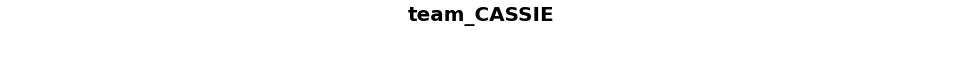

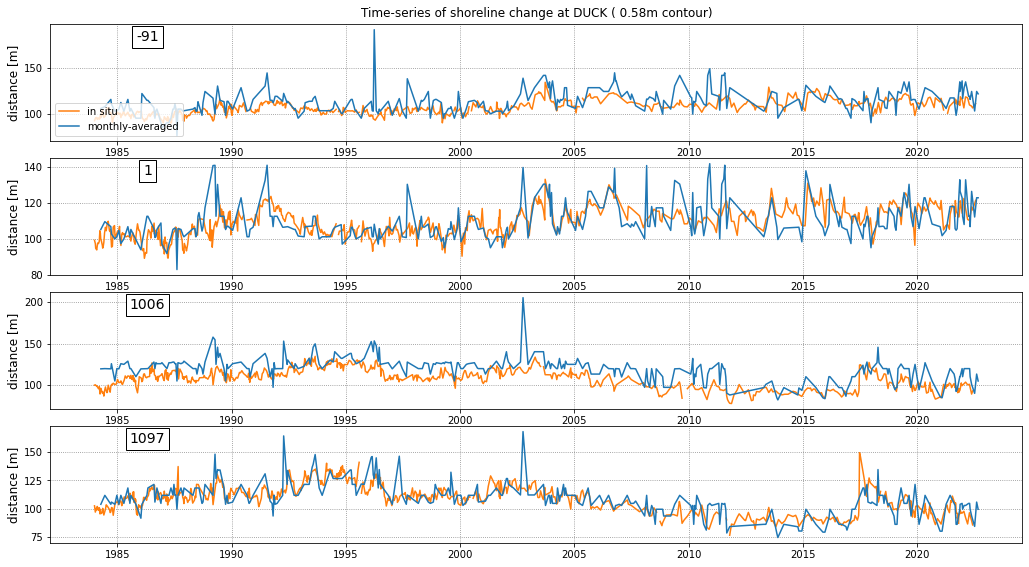

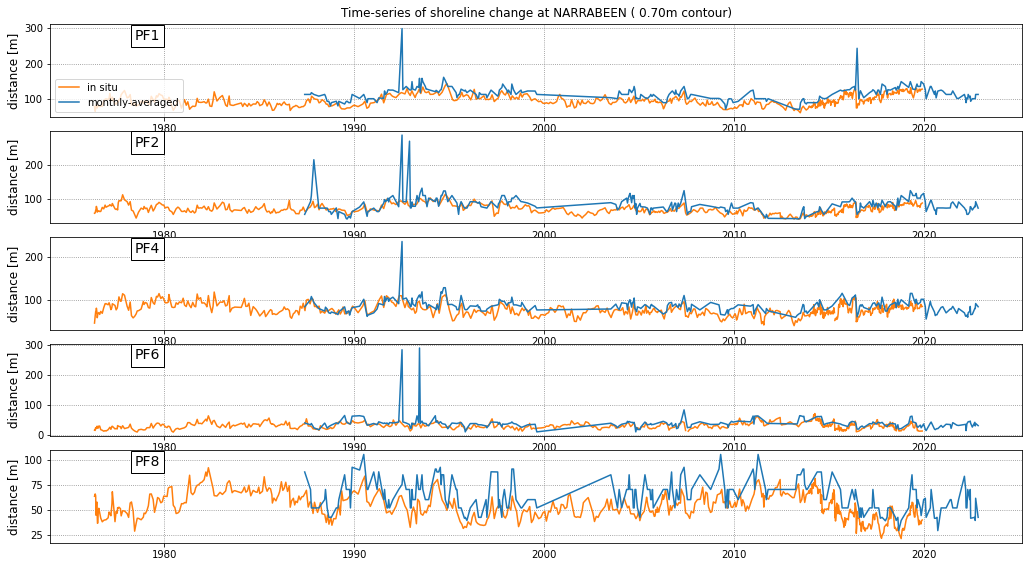

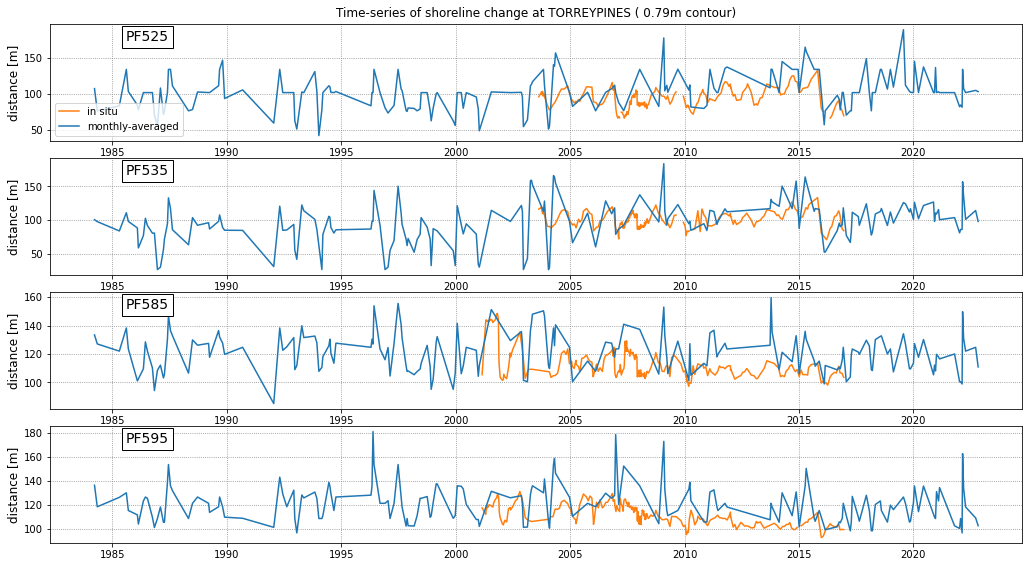

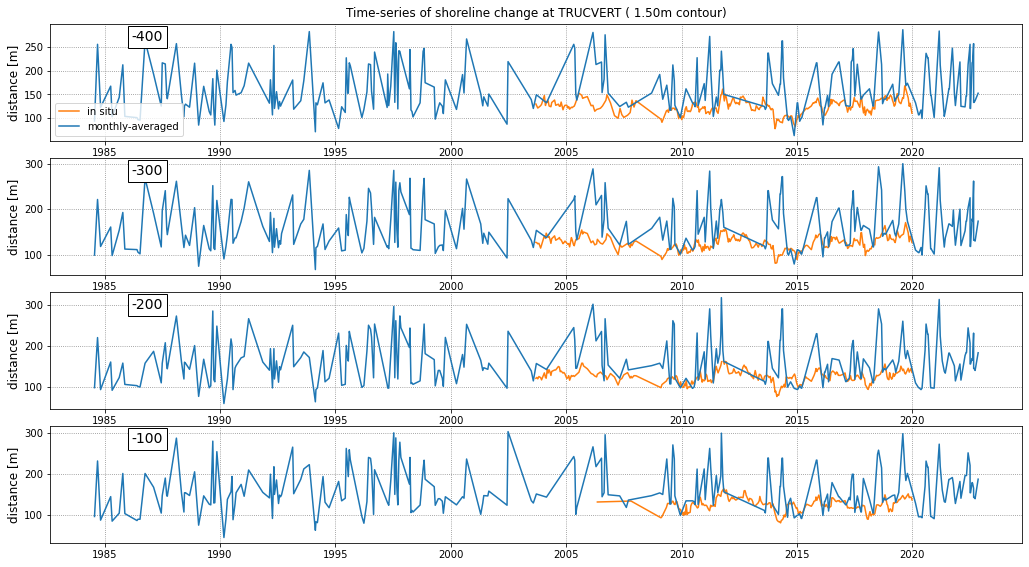

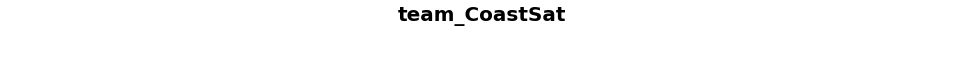

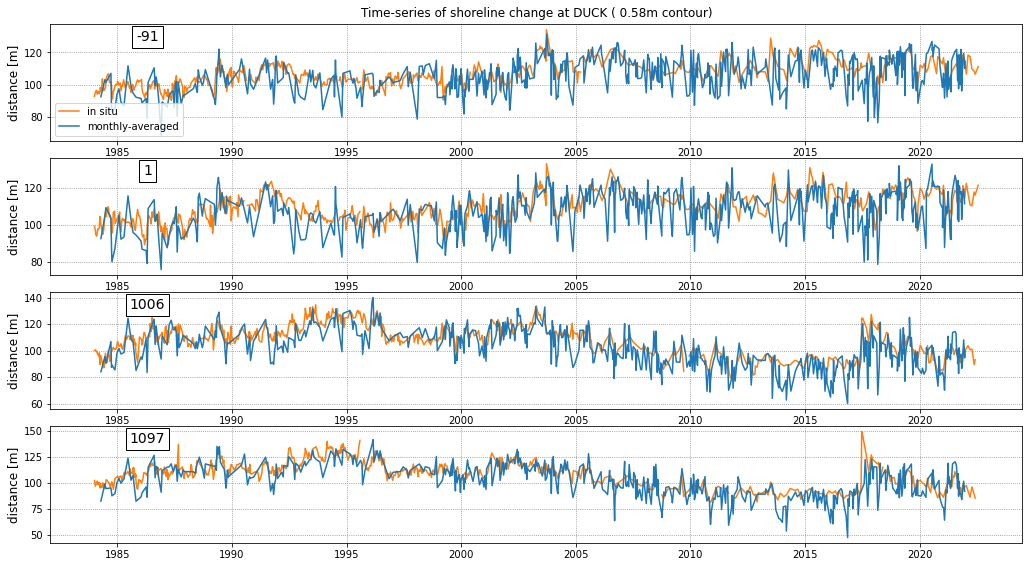

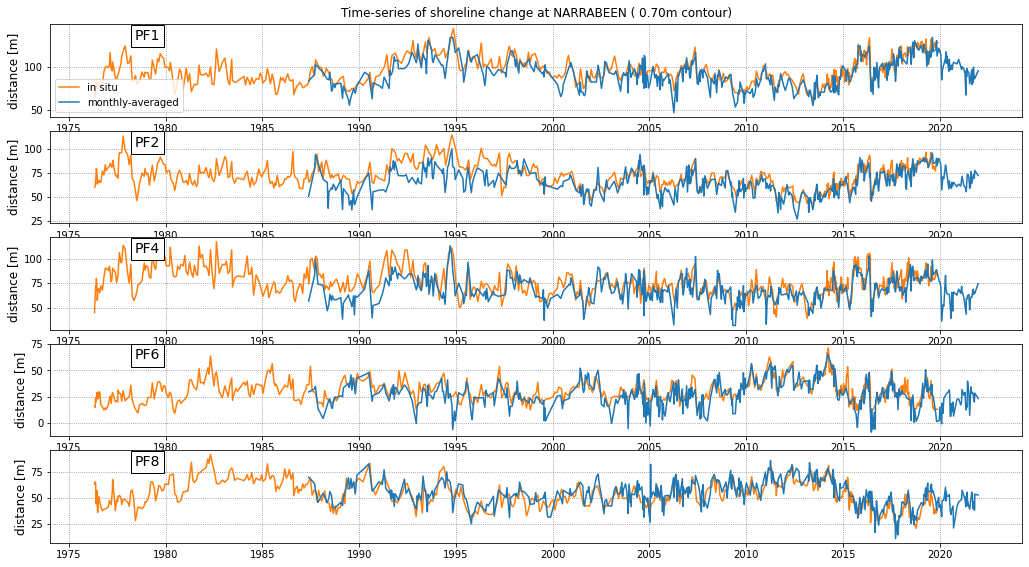

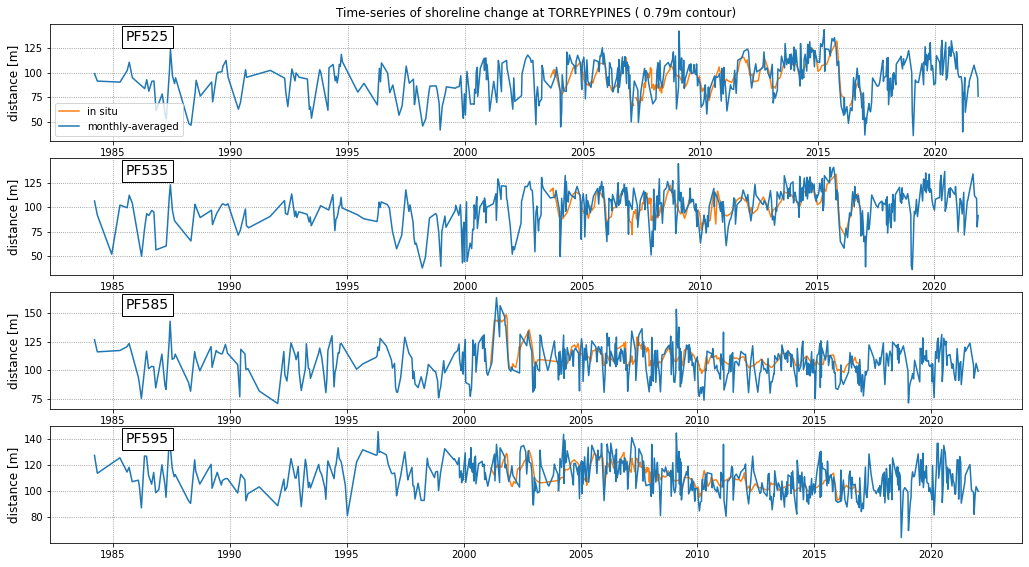

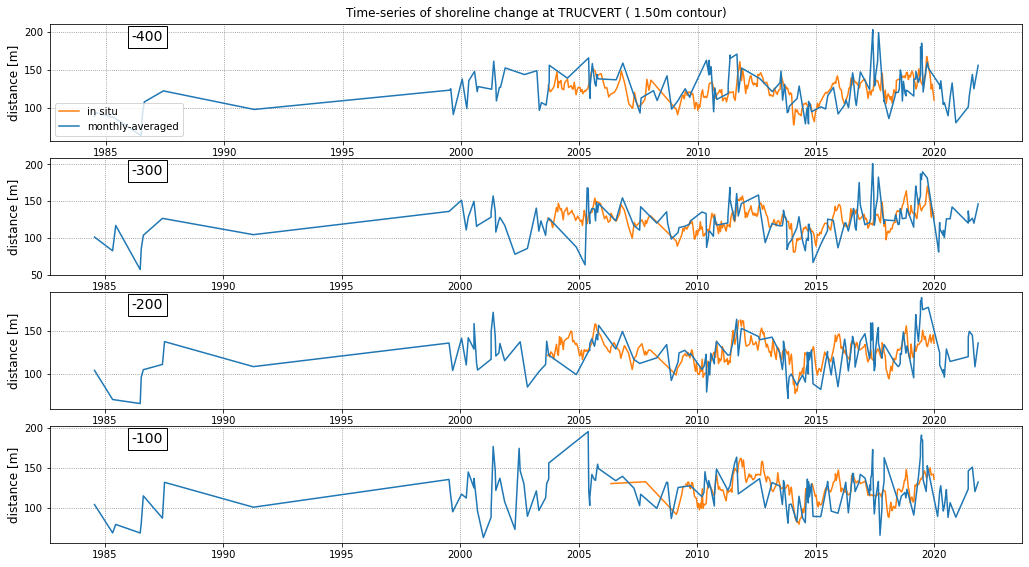

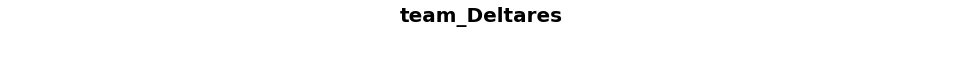

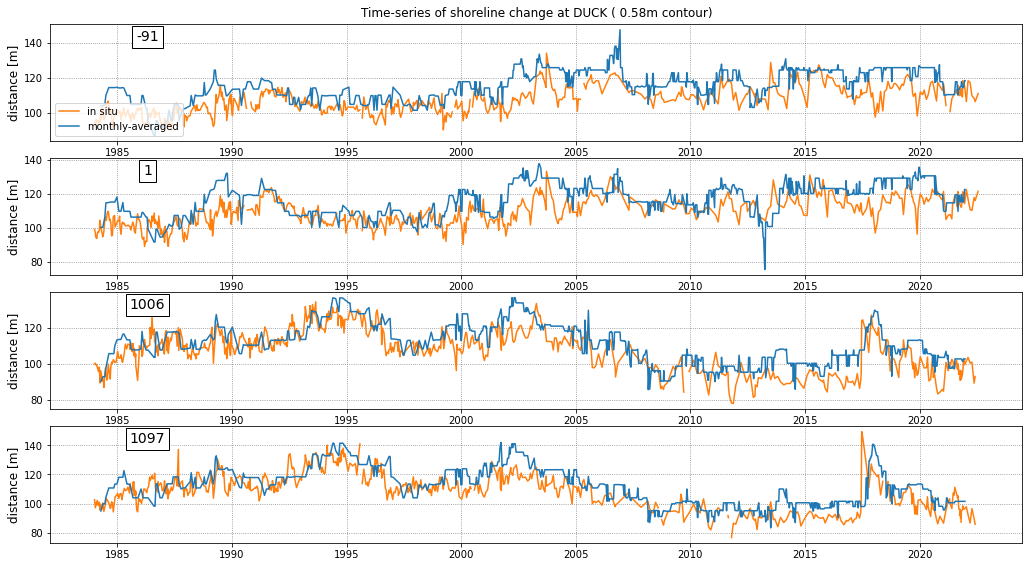

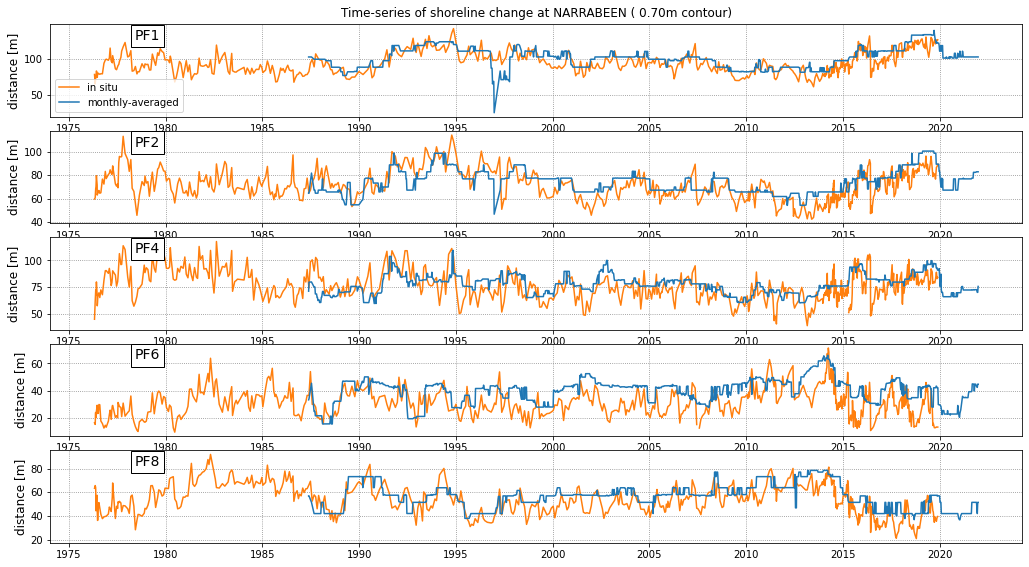

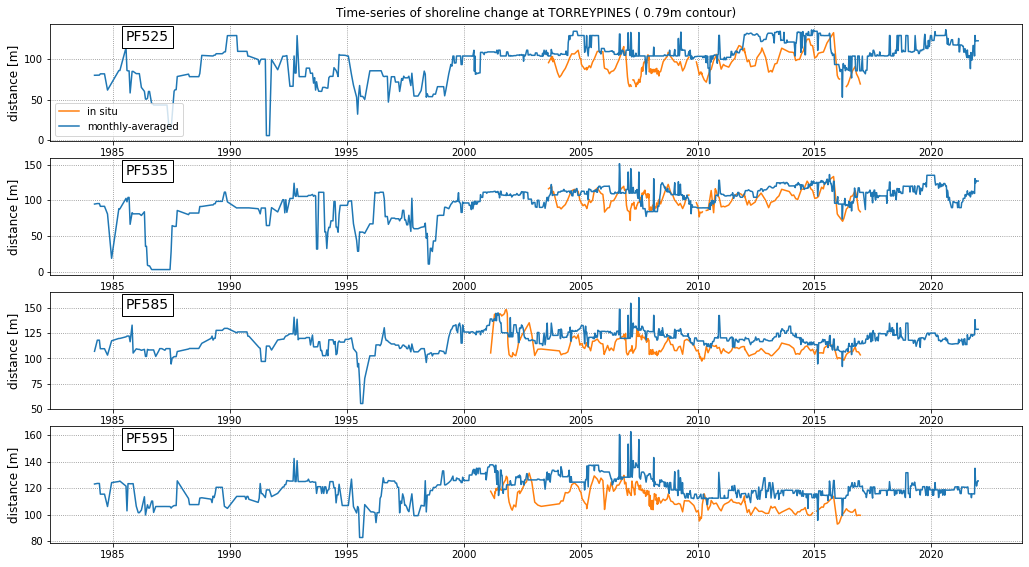

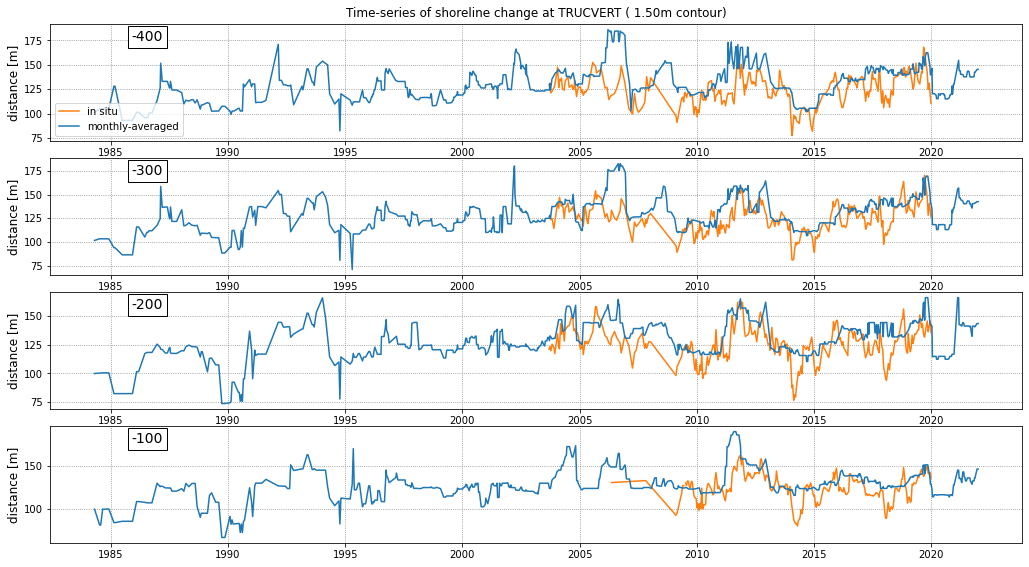

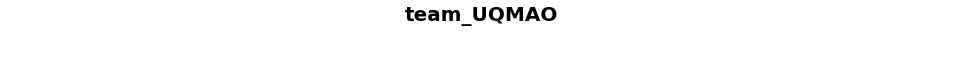

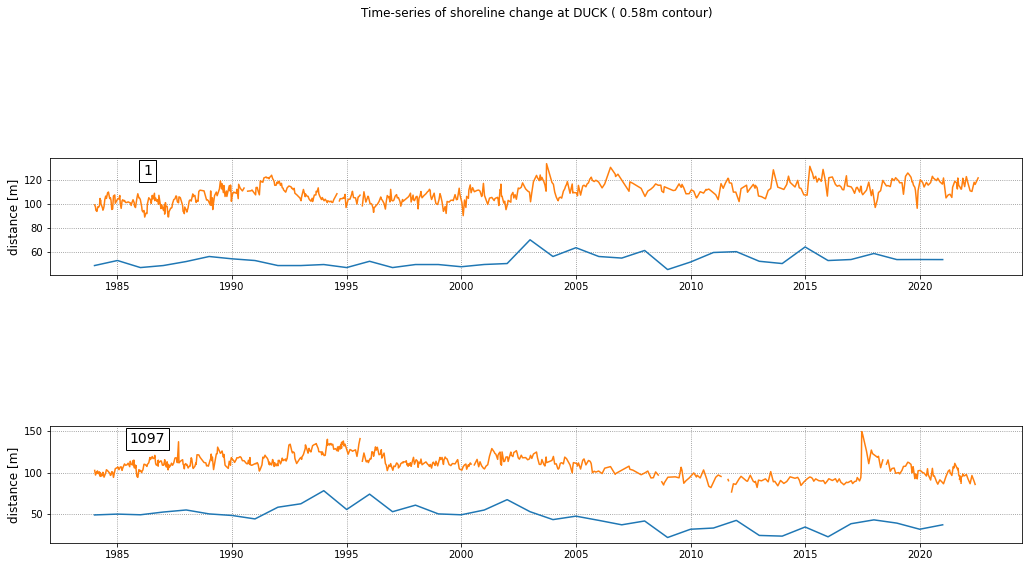

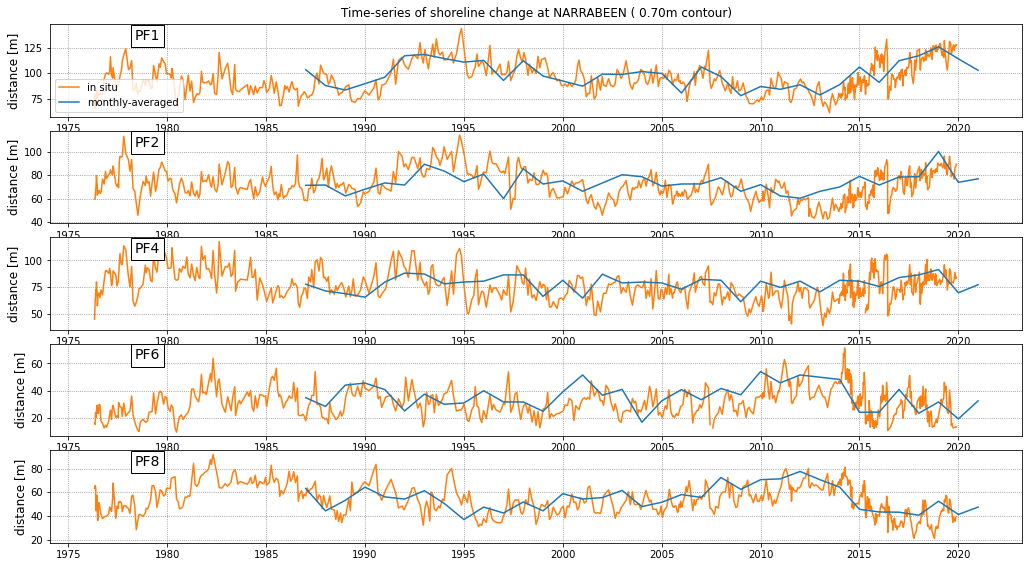

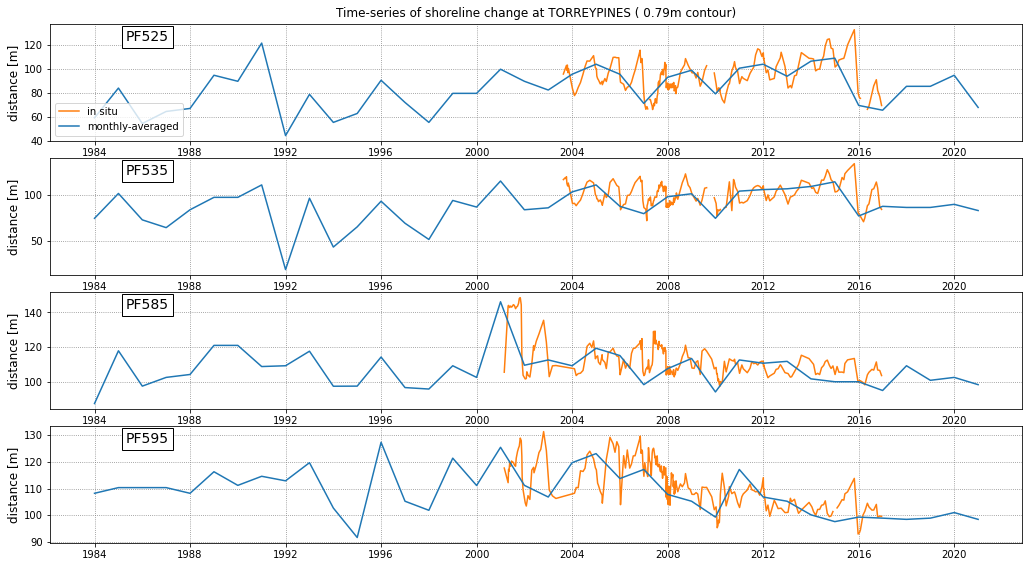

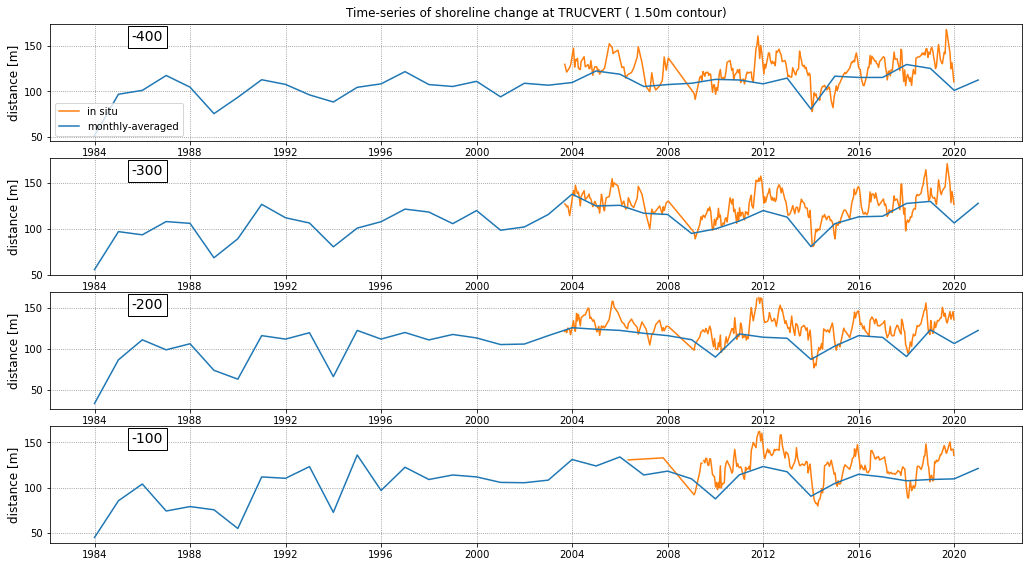

In [25]:
# load formatted submissions
with open('submitted_timeseries.pkl','rb') as f:
    sub_output = pickle.load(f)
# selected transects for comparison with groundtruth
selected_transects = {
    'NARRABEEN': ['PF1','PF2','PF4','PF6','PF8'],
    'DUCK':      ['-91','1','1006','1097'],
    'TRUCVERT':   ['-400','-300','-200','-100'],
    'TORREYPINES':['PF525','PF535','PF585','PF595'],    
    }
# loop through submissions
for sub in submissions:
    submission_folder = os.path.join(fp_submissions,sub)
    submission_sites = os.listdir(submission_folder)
    fig = plt.figure(figsize=[17,0.5], tight_layout=True)
    plt.title(sub,fontsize=20,fontweight='bold')
    plt.axis('off')
    # loop through sites
    for sitename in names_datasets:
        # skip site if it wasn't mapped
        if sitename not in submission_sites: continue
        transects = selected_transects[sitename]
        # load groundtruth
        data_folder = os.path.join(fp_datasets,sitename)
        with open(os.path.join(data_folder, '%s_groundtruth.pkl'%sitename), 'rb') as f:
            gt = pickle.load(f)
        # make plot comparing the time-series
        fig = plt.figure(figsize=[15,8], tight_layout=True)
        fig.suptitle('Time-series of shoreline change at %s ( %.2fm contour)'%(sitename,sites_info[sitename]['contour_level']))
        gs = gridspec.GridSpec(len(transects),1)
        gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.15)
        # plot transects
        for i,key in enumerate(transects):
            if key not in sub_output[sub][sitename].keys(): continue
            dates = sub_output[sub][sitename][key]['dates']
            chain = sub_output[sub][sitename][key]['chainage']
            # plot time-series
            ax = fig.add_subplot(gs[i,0])
            ax.plot(gt[key]['dates'], gt[key]['chainages'],'C1-',label='in situ')
            ax.grid(b=True,linestyle=':', color='0.5')
            ax.plot(dates, chain, '-', lw=1.5, color='C0', mfc='w', ms=4, label='monthly-averaged')
            ax.set_ylabel('distance [m]', fontsize=12)
            ax.text(0.1,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
                    va='top', transform=ax.transAxes, fontsize=14) 
            if i == 0: ax.legend(loc='lower left') 

### Accuracy assessment of the satellite-derived shoreline time-series

This section evaluate the horizontal accuracy of the satellite-derived time-series of shoreline change.
The user can select the transects over which to evaluate the time-series and a few parameters for the assessment:
- `min_days`: 3 days (default), number of days over which it can be assumed that the shoreline has not change. If a survey is located within this time window, it is compared directly to the satellite shorelines.
- `max_days`: 10 days (default), number of days after which a comparison is not realistic any more due to shoreline changes. Between `min_days` and `max_days`, the surveyed shoreline time-series are interpolated to match the date of the satellite shoreline points.

There are also 2 visualisation parameters, the `binwidth` to use when plotting the histogram distributions and the limits (`lims`) over which to plot the errors.  

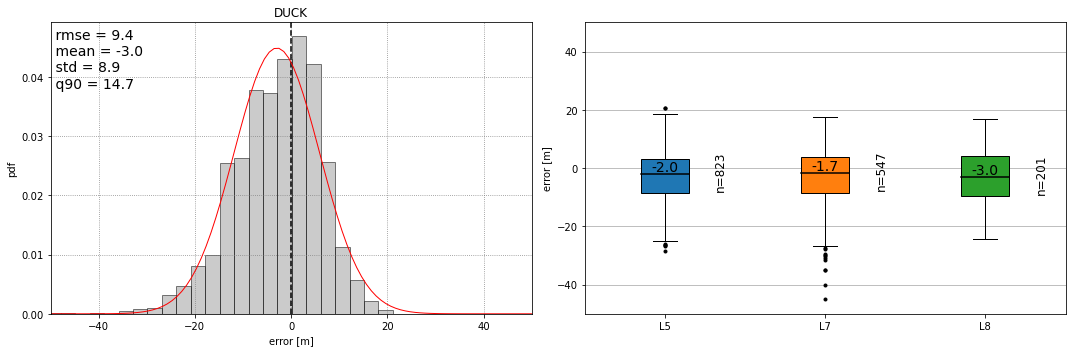

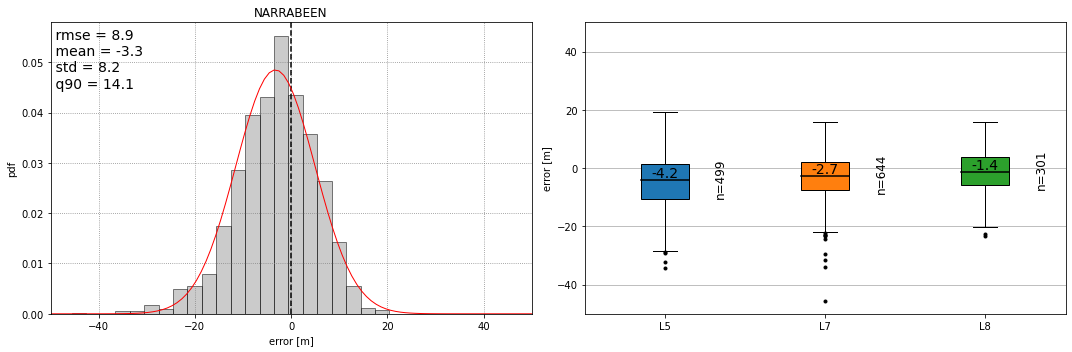

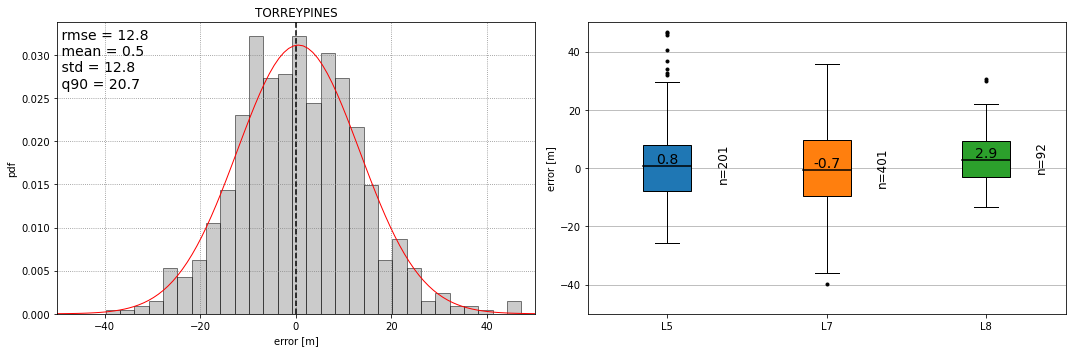

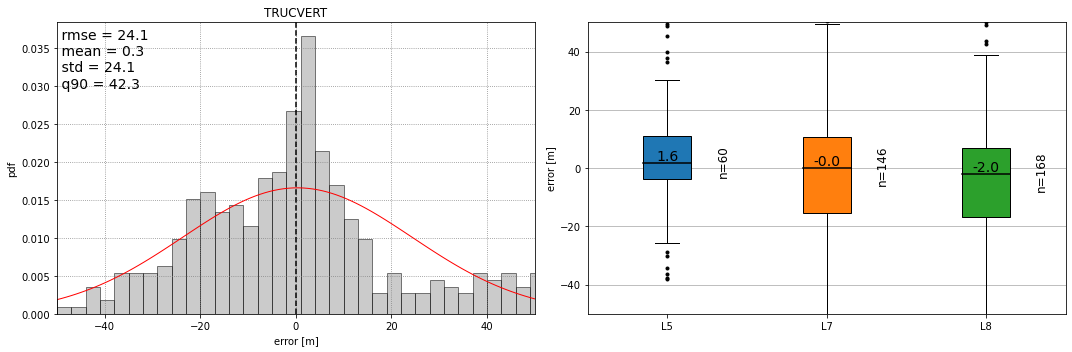

In [40]:
# submission team name
submission_name = 'team_COASTSAT'
# type of submission (tidally-corected_timeseries or raw_timeseries)
submission_type = 'tidally_corrected_timeseries'
submission_folder = os.path.join(os.getcwd(),'submissions',submission_name)
submission_sites = os.listdir(submission_folder)
# create folder to store comparisons
output_folder = os.path.join(submission_folder,'evaluation_%s'%submission_type)
if not os.path.exists(output_folder): os.makedirs(output_folder)
transect_folder = os.path.join(output_folder,'by_transect')
if not os.path.exists(transect_folder): os.makedirs(transect_folder)
# selected transects for comparison with groundtruth
selected_transects = {
    'NARRABEEN': ['PF1','PF2','PF4','PF6','PF8'],
    'DUCK':      ['-91','1','1006','1097'],
    'TRUCVERT':   ['-400','-300','-200','-100'],
    'TORREYPINES':['PF525','PF535','PF585','PF595'],    
    }
# parameters for evaluation
settings = {
    'min_days':  3,           # numbers of days difference under which to use nearest neighbour interpolation
    'max_days':  10,          # maximum number of days difference to do a comparison
    'binwidth':  3,           # binwidth for histogram plotting
    'lims':      [-50,50]     # cross-shore change limits for plotting purposes
           }
# loop through sites
for sitename in names_datasets:
    if sitename not in submission_sites: continue
    # load groundtruth
    data_folder = os.path.join(fp_datasets,sitename)
    with open(os.path.join(data_folder, '%s_groundtruth.pkl'%sitename), 'rb') as f:
        gt = pickle.load(f) 
    # load satellite time-series
    fp_tc_timeseries = os.path.join(submission_folder,sitename,submission_type)
    fn_transects = os.listdir(fp_tc_timeseries)
    transects = selected_transects[sitename]
    # evaluate the time-series along each transect
    chain_sat_all, chain_sur_all, satnames_all = [], [], []
    for key in transects:
        # load satellite time-series
        fp_ts = os.path.join(fp_tc_timeseries,'%s_timeseries_tidally_corrected.csv'%key)
        ts = pd.read_csv(fp_ts,parse_dates=['dates'])
        ts_sat, ts_sur, satnames, fig = utils.compare_timeseries(ts,gt,key,settings)
        fig.savefig(os.path.join(transect_folder,'%s_transect_%s.jpg'%(sitename,key)), dpi=200)
        plt.close(fig)
        chain_sat_all = np.append(chain_sat_all,ts_sat)
        chain_sur_all = np.append(chain_sur_all,ts_sur)
        satnames_all = satnames_all + satnames 
    # calculate statistics for all transects together
    chain_error = chain_sat_all - chain_sur_all
    slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur_all, chain_sat_all)
    R2 = rvalue**2
    rmse = np.sqrt(np.mean((chain_error)**2))
    mean = np.mean(chain_error)
    std = np.std(chain_error)
    q90 = np.percentile(np.abs(chain_error), 90)
    fig,ax = plt.subplots(1,2,figsize=(15,5), tight_layout=True)
    # histogram
    ax[0].grid(which='major',linestyle=':',color='0.5')
    ax[0].axvline(x=0, ls='--', lw=1.5, color='k')
    binwidth = settings['binwidth']
    bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
    density = ax[0].hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
    mu, std = stats.norm.fit(chain_error)
    pval = stats.normaltest(chain_error)[1]
    xlims = settings['lims']
    x = np.linspace(xlims[0], xlims[1], 100)
    p = stats.norm.pdf(x, mu, std)
    ax[0].plot(x, p, 'r-', linewidth=1)
    ax[0].set(xlabel='error [m]', ylabel='pdf', xlim=settings['lims'], title=sitename)
    str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90)
    ax[0].text(0, 0.98, str_stats,va='top', transform=ax[0].transAxes,fontsize=14)
    # boxplot
    data = []
    median_data = []
    n_data = []
    ax[1].yaxis.grid()
    for k,sat in enumerate(list(np.unique(satnames_all))):
        idx = np.where([_ == sat for _ in satnames_all])[0]
        data.append(chain_error[idx])
        median_data.append(np.median(chain_error[idx]))
        n_data.append(len(chain_error[idx]))
    bp = ax[1].boxplot(data,0,'k.', labels=list(np.unique(satnames_all)), patch_artist=True)
    for median in bp['medians']:
        median.set(color='k', linewidth=1.5)
    for j,boxes in enumerate(bp['boxes']):
        boxes.set(facecolor='C'+str(j))
        ax[1].text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=14)
        ax[1].text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
    ax[1].set(ylabel='error [m]', ylim=settings['lims']);
    fig.savefig(os.path.join(output_folder,'%s_evaluation.jpg'%(sitename)), dpi=200)